# 1. Startup Application and Internal Memory 

In [11]:
%cd ..
!ls
!pip install -r requirements.txt --quiet

/Users/diogosilva/Documents/Scalable ML and DeepL/Project-ID2223_TrafficApp
README.md             functions             requirements.txt
__pycache__           hopsworks-api-key.txt tests.ipynb
cache                 keys.py               variables
figures               notebooks


In [12]:
import pickle
import pandas as pd
import hopsworks
import os

from keys import TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3
from functions.TomTomAPI import get_traffic_map, plot_traffic_map, get_grid_from_map, get_traffic_map_from_grid, get_grid_from_map_alt
from functions.HolidaysnWeather import get_weather, is_holiday

In [13]:
coordinates = 59.34318, 18.05141 # Stockholm near Odenplan
radius = 1000
zoom = 20

TOMTOM_keys = [TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3]

### 1.1. Create GRID for extracting traffic data

In [14]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map = get_traffic_map(TOMTOM_keys[i], coordinates, radius, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

eliminated: 7
eliminated: 3
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
eliminated: 2
eliminated: 2
eliminated: 1
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}


1145
280


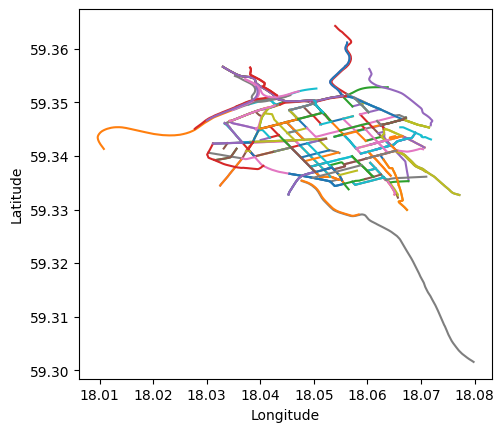

In [15]:
print(len(traffic_map))
traffic_map = set([str(s) for s in traffic_map])
traffic_map = [eval(s) for s in list(traffic_map)]
print(len(traffic_map))

plot_traffic_map(traffic_map)

In [16]:
grid = get_grid_from_map_alt(traffic_map)

with open('variables/grid.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(grid, file)

### 1.2. Collect traffic data

num of requests: 280
280
182


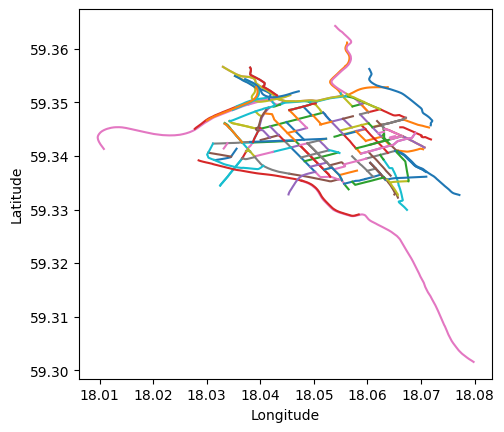

In [17]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map2 = get_traffic_map_from_grid(TOMTOM_keys[i],grid, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

print(len(traffic_map2))
traffic_map2 = set([str(s) for s in traffic_map2])
traffic_map2 = [eval(s) for s in list(traffic_map2)]
print(len(traffic_map2))

plot_traffic_map(traffic_map2, name = 'figures/traffic_map2.png')

In [18]:
from shapely.geometry import LineString
import datetime

traffic_df = pd.DataFrame(traffic_map2)
traffic_df['coordinates'] = traffic_df['coordinates'].apply(lambda x: LineString([(point['longitude'], point['latitude']) for point in x['coordinate']]))
traffic_df = traffic_df.drop_duplicates()

traffic_df['relativeSpeed'] = traffic_df.apply(lambda x: x['currentSpeed'] - x['freeFlowSpeed'], axis = 1)

today = datetime.datetime.now()
today = today.replace(second=0, microsecond=0, minute=0, hour=today.hour) + datetime.timedelta(hours=today.minute//30)
dates = [today for i in range(traffic_df.shape[0])]
multi_index = pd.MultiIndex.from_arrays(
    [dates,traffic_df['frc'], traffic_df['coordinates']],  # Pass as a list of arrays
    names=['date','frc', 'coordinates']  # Assign level names
)
traffic_df.index = multi_index

traffic_df = traffic_df.drop(columns = ['@version','frc', 'coordinates'])

print(traffic_df.shape)
traffic_df.head(1)

(182, 7)


,,,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,confidence,roadClosure,relativeSpeed
date,frc,coordinates,,,,,,,
2024-12-18 11:00:00,FRC5,"LINESTRING (18.0457292120079 59.34158925052537, 18.045912943325447 59.3413907612665, 18.046045712671713 59.3412486039483, 18.046544603548625 59.34075506639119, 18.046655915222743 59.34064509121004, 18.046733699284204 59.34056730054431, 18.04697643920008 59.340323241859785, 18.047094456396792 59.340205229667184, 18.047176263771746 59.34012205241007, 18.04758530064663 59.33971035190797, 18.047826699458028 59.33946491927185, 18.047986290894443 59.33930937510008, 18.048271946154614 59.339015638738964, 18.048938475094957 59.33833570112772, 18.049159757338742 59.338109066481174, 18.049293867789515 59.337970913499106, 18.049976489983976 59.337284286552325, 18.05023666425845 59.33702143851012)",19,27,107,75,1.0,False,-8


### 1.3. Collect weather data

In [19]:
weather_df = get_weather(coordinates)
weather_df

,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2024-12-18 11:00:00,5.626,-0.674,4.6,24.119999,186.772873


### 1.4. Collect weather data

In [20]:
holiday_status = is_holiday()
weather_df['holiday_status'] = holiday_status
weather_df

,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,holiday_status
2024-12-18 11:00:00,5.626,-0.674,4.6,24.119999,186.772873,0


### 1.5. Joining data and uploading to Hopsworks

In [23]:
# Get the API key from GitHub Secrets
# HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')
with open('hopsworks-api-key.txt','r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

# Get AQI API KEY from secrets of hopsworks
project = hopsworks.login(project="ID2223LAB1KTH", api_key_value=os.environ["HOPSWORKS_API_KEY"])

2024-12-18 11:20:38,266 INFO: Closing external client and cleaning up certificates.
2024-12-18 11:20:38,273 INFO: Initializing external client
2024-12-18 11:20:38,274 INFO: Base URL: https://c.app.hopsworks.ai:443


ConnectTimeout: HTTPSConnectionPool(host='c.app.hopsworks.ai', port=443): Max retries exceeded with url: /hopsworks-api/api/variables/versions (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x1321278f0>, 'Connection to c.app.hopsworks.ai timed out. (connect timeout=None)'))

In [ ]:

# Initialize the feature store

fs = project.get_feature_store()

# Define and insert the Air Quality Feature Group
traffic_fg = fs.get_or_create_feature_group(
    name="stockholm_traffic",
    version=1,
    description="Traffic data of odenplan : coordinates currentSpeed	freeFlowSpeed	currentTravelTime	freeFlowTravelTime	confidence	roadClosure",
    primary_key=["date"],  
    event_time="date" 
)

traffic_fg.insert(traffic_df)

# Define and insert the Air Quality Feature Group
weather_fg = fs.get_or_create_feature_group(
    name="stockholm_weather&holiday",
    version=1,
    description="Weather data for Stockholm including temperature, precipitation, wind speed and holiday",
    primary_key=["date"],  
    event_time="date" 
)

weather_fg.insert(weather_df)